In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [3]:
df = pd.read_excel("DATA TRAINING WARNING DO NOT DELETE.xlsx")

In [4]:
df['sentiment'] = df['sentiment'].fillna(value=2)
df['sentiment'] = df['sentiment'].astype(int)
df['text'] = df['text'].replace('\s+', ' ', regex=True)
df['text'] = df['text'].fillna('').apply(str)
df['text'] = df['text'].replace({'"':'',
                                 '\d+':'',
                                 ':':'',
                                 ';':'',
                                 '#':'',
                                 '@':'',
                                 '_':'',
                                 ',': '',
                                 "'": '',
                                  }, regex=True)

df['text'] = df['text'].str.replace(r'[https]+[?://]+[^\s<>"]+|www\.[^\s<>"]+[?()]+[(??)]+[)*]+[(\xa0]+[-&gt...]', "",regex=True)

df['text'] = df['text'].replace('\n','', regex=True)

df['text'] = df['text'].replace({'\.':'','(/)':'','\(':'','\)':''},regex=True)
df['text'] = df['text'].replace('[\.:"]','',regex =True)

df['text'] = df['text'].fillna('').apply(str)

df['text'].astype(str)
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df['text']))
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.lower()

In [5]:
df['sentiment'] = df['sentiment'].replace({1:0,2:1,3:2})
df.head(100)

,text,sentiment,Unnamed: 2
0,menurut johnny g plate upaya itu sama seperti ...,1,NaN
1,raymax justbob adisareang wah punya pt pos ind...,1,NaN
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,1,NaN
3,telegram bukannya jaman jadul banget tuh produ...,2,NaN
4,agenda transformatif ini tidak hanya ditujukan...,2,NaN
...,...,...,...
95,bravobeacukai dimana saya bisa hubungi pos ind...,1,NaN
96,bravobeacukai punten ingin tanya kakkalau impo...,1,NaN
97,briankhis amaan kok tegantung deh kan ada mace...,1,NaN
98,brklynbrnx paket lbde sudah rilis dan lunas pa...,1,NaN


In [6]:
df_neg = df[df['sentiment'] == 0]
df_net = df[df['sentiment'] == 1]
df_pos = df[df['sentiment'] == 2]
print(f"negatif shape {df_neg.shape}")
print(f"netral shape {df_net.shape}")
print(f"postif shape {df_pos.shape}")
print(f"total shape {df.shape}")

negatif shape (404, 3)
netral shape (484, 3)
postif shape (640, 3)
total shape (1528, 3)


In [7]:
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
vocab_size = 20000
embedding_dim = 10
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [28]:
import numpy as np
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index =tokenizer.word_index

training_sequence = tokenizer.texts_to_sequences(X_train)
testing_sequence = tokenizer.texts_to_sequences(X_test)

training_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)
test_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)

training_padded = np.array(training_padding)
training_label = np.array(y_train)

test_padded = np.array(test_padding)
test_label = np.array(y_test)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(max_length)),
    tf.keras.layers.Dense(40,activation='sigmoid'),
    tf.keras.layers.Dense(3,activation='sigmoid')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
num_epoch = 300
history = model.fit(training_padded,training_label,batch_size = 32,epochs=num_epoch)

Epoch 1/300
39/39 [==============================] - 8s 155ms/step - loss: 1.1169 - accuracy: 0.3797

In [31]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


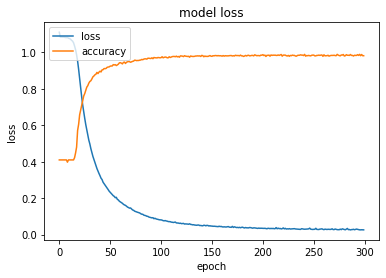

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [33]:
sentence = ["kurir pos lama"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
predic2 = model.predict(padded)
print(predic2)

[[0.94841677 0.8928253  0.00177014]]


In [34]:
import numpy as np
y_label = {0:"negative",1:"neutral",2:"positive"}
prediction = np.array(predic2)
print(y_label[np.argmax(prediction)])


negative


In [72]:
data_predict = pd.read_excel("data clear.xlsx")
data_predict = data_predict.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
data_predict.head()
data_predict = data_predict.dropna()
data_predict.isna().sum()
data_predict

,text
0,ayo jawab siapa yg baru tau kalau pos indonesi...
1,oktober memperingati hari kesaktian pancasila ...
2,alasan sederhana mau coba download pospayoffic...
3,tercatat sampai dengan semester i pertumbuhan ...
4,digitalisasi di tubuh pt pos indonesia diwujud...
...,...
874,unfortunately pos malaysia only delivers to th...
875,kapankah anda terakhir kali menulis surat masi...
876,po case album aespa savage ditunggu sampai k ...
877,checkout all nominal shopee split pay shopeepa...


In [73]:
data = data_predict['text'].tolist()
data[:5]

['ayo jawab siapa yg baru tau kalau pos indonesia punya ewallet bernama pospayofficial utk mendukung langkah bumn utk negeri install dan aktivasi pospay dr skrg yuk banyak bonus yg akan didapat dan jg bentuk dr aksi nyata kita dukung karya hebat bumn',
 'oktober memperingati hari kesaktian pancasila bersama pospayofficial keren sih tagline nya selalu tangguh di mana saja sbg informasi pospay adalah ewallet keluaran bumn pos indonesia',
 'alasan sederhana mau coba download pospayofficial adl dalam rangka mendukung karya bumn aplikasi ini layak diapresiasi sbg salah satu ikhtiar pos indonesia utk negeri',
 'tercatat sampai dengan semester i pertumbuhan bisnis pt pos indonesia mencapai dibandingkan dengan tahun lalu semua ini berkat kehadiran platform digital pakaipospay tiorichardo airinairinnz andreopasumual warhasnotendyet kontannews',
 'digitalisasi di tubuh pt pos indonesia diwujudkan dengan diluncurkannya dua aplikasi produk layanan untuk semakin memudahkan pelanggan salah satunya a

In [74]:
sequences_pred = tokenizer.texts_to_sequences(data)
padded_pred = pad_sequences(sequences_pred,maxlen=max_length,padding=padding_type,truncating=trunc_type)
input_prediction = model.predict(padded_pred)
input_prediction[:3]

array([[8.7850182e-08, 2.2138220e-01, 9.9998689e-01],
       [1.8635806e-07, 4.8451406e-01, 9.9992114e-01],
       [3.5636850e-07, 2.2279164e-01, 9.9996406e-01]], dtype=float32)

In [75]:
y_label = {0:"negative",1:"neutral",2:"positive"}
pred_res = np.array(input_prediction)
print(pred_res[:4])

[[8.7850182e-08 2.2138220e-01 9.9998689e-01]
 [1.8635806e-07 4.8451406e-01 9.9992114e-01]
 [3.5636850e-07 2.2279164e-01 9.9996406e-01]
 [5.6808068e-07 2.2339603e-01 9.9994898e-01]]


In [76]:
sentimen = []
for x in pred_res:
    sentimen.append(y_label[np.argmax(x)])

In [77]:
sentimen

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive'

In [78]:
data_clean = pd.DataFrame({'tweet':data_predict['text'],'sentimen':sentimen})
data_clean

,tweet,sentimen
0,ayo jawab siapa yg baru tau kalau pos indonesi...,positive
1,oktober memperingati hari kesaktian pancasila ...,positive
2,alasan sederhana mau coba download pospayoffic...,positive
3,tercatat sampai dengan semester i pertumbuhan ...,positive
4,digitalisasi di tubuh pt pos indonesia diwujud...,positive
...,...,...
874,unfortunately pos malaysia only delivers to th...,negative
875,kapankah anda terakhir kali menulis surat masi...,negative
876,po case album aespa savage ditunggu sampai k ...,neutral
877,checkout all nominal shopee split pay shopeepa...,neutral


In [79]:
data_clean.to_excel("tensorflow testing sentimen 2.xlsx")

